# Churn analysis and prediction for gambling operations 🦁

# Upload and clean dataset

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.9 MB/s eta 0:00:00


In [ ]:
# Import libraries needed
import pandas as pd
import seaborn as sns
import io
import matplotlib.pyplot as plt
import numpy as np
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

from google.colab import files

In [ ]:
# Upload the data
uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
# Read the data
df = pd.read_csv(io.BytesIO(uploaded['data.csv']))
df.head()

user_id        date     vertical  turnover_cash_num  \
0 -4233848618748012971  2020-06-19       sports                  4   
1  2814934526452133975  2020-09-14  casino_live                123   
2  3718332242005503191  2020-09-06  casino_live                399   
3 -5271561423861853461  2020-09-06  casino_live                 60   
4 -3697770787649913393  2020-07-25  casino_live                 13   

   turnover_cash_sum  deposit_approved_num  deposit_approved_sum  \
0          41.662354                     0                   0.0   
1         847.111687                     0                   0.0   
2       21111.275179                     0                   0.0   
3         825.512773                     0                   0.0   
4         105.128915                     0                   0.0   

   withdrawal_approved_num  withdrawal_approved_sum      NGR_sum  session_num  \
0                        0                      0.0    59.875489            0   
1                        0                      0.0    81.685770            0   
2                        0                      0.0  2731.476087            0   
3                        0                      0.0  -364.196812            0   
4                        0                      0.0   105.128915            0   

   session_sum  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

The dataset consists of 7k customers described along the following features:

* `user_id` unique identifier of a customer
* `date` date
* `vertical` breakdown of vertical for the other features, some features are
  vertical agnostic
* `turnover_cash_num` number of bets placed with real money
* `turnover_cash_sum` sum of bets placed with real money
* `deposit_approved_num` number of approved deposits
* `deposit_approved_sum` sum of approved deposits
* `withdrawal_approved_num` number of approved withdrawals
* `withdrawal_approved_sum` sum of approved withdrawals
* `NGR_sum` net gaming revenue, i.e. difference between turnover and winnings
* `session_num` number of sessions
* `session_sum` total length of sessions

In [ ]:
# Check for missing values
df.isna().any()

user_id                    False
date                       False
vertical                    True
turnover_cash_num          False
turnover_cash_sum          False
deposit_approved_num       False
deposit_approved_sum       False
withdrawal_approved_num    False
withdrawal_approved_sum    False
NGR_sum                    False
session_num                False
session_sum                False
dtype: bool

In [ ]:
df.vertical.unique()

NameError: name 'df' is not defined

In [ ]:
# Group by user_id and date and sum values for each vertical
df = df.groupby(['user_id', 'date']).sum('vertical').reset_index()
df.head()

user_id        date  turnover_cash_num  turnover_cash_sum  \
0 -9221951630658075946  2020-12-26               5822        4459.209597   
1 -9221578899823807595  2020-03-15              14323       53473.144171   
2 -9221578899823807595  2020-03-27               6626       12641.008185   
3 -9221578899823807595  2020-03-28               2994       10355.728691   
4 -9221578899823807595  2020-04-07               8464       20901.886683   

   deposit_approved_num  deposit_approved_sum  withdrawal_approved_num  \
0                     4            185.261341                        0   
1                    16           1730.802530                        4   
2                    13           2057.958190                        0   
3                     7           1364.466037                        0   
4                    32           2643.989516                        0   

   withdrawal_approved_sum      NGR_sum  session_num   session_sum  
0                 0.000000    13.113415           10  30611.678817  
1              5048.174046 -3333.641060           10  95447.868001  
2                 0.000000  1721.024702            4  41267.961098  
3                 0.000000  1715.247514            4  19622.387714  
4                 0.000000  2640.828224            4  53209.154774

In [ ]:
# Drop duplicates and sort values
df.drop_duplicates(inplace=True)
df.sort_values(by='date', inplace=True)

# Feature engineering, assumptions and correlations

**Assumptions:**

- No activity in the last 30 days or no activity within 30 days after first deposit is defined as 'churned'. The first activity for each user is a deposit since dataset contains customers who made their first
deposit during a calendar year. These two conditions are selected since they are widely used in research and application to define online gambling churn rates. Using both conditions enables a larger net to be able to catch all possible churn customers. This is important since the use of two conditions is relatively straightforward and less costly than losing customers to undefined churn conditions.
- Churn condition is selected as the target variable as it is the objective of this exercise.
- Same user activity in different verticals are treated seperately as their engagement might differ.
- If there are no number or sum entries (=0), averages are also calculated as 0 to keep the integrity of the data intact (to prevent inf values).


In [ ]:
# Calculate days until first activity after first deposit
df['first_deposit_date'] = df.groupby('user_id')['date'].transform('min')
df['days_since_first_deposit'] = (pd.to_datetime(df['date']) - pd.to_datetime(df['first_deposit_date'])).dt.days
df['days_to_first_activity'] = df.groupby(['user_id'])['days_since_first_deposit'].transform('min')

In [ ]:
# Days since last activity
df['days_since_activity'] = pd.to_datetime(df['date'].max()) - pd.to_datetime(df.groupby('user_id')['date'].transform('max'))
df.days_since_activity = df.days_since_activity.dt.days

In [ ]:
# Calculate averages
df['turnover_cash_avg'] = round(df['turnover_cash_sum'] / df['turnover_cash_num'])
df['deposit_approved_avg'] = round(df['deposit_approved_sum'] / df['deposit_approved_num'])
df['withdrawal_approved_avg'] = round(df['withdrawal_approved_sum'] / df['withdrawal_approved_num'])
df['session_avg'] = round(df['session_sum'] / df['session_num'])

# Replace NaN and inf with 0
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [ ]:
# Find the first non-zero turnover cash average date for each user
df_first_turnover = df[df['turnover_cash_avg'] != 0].groupby('user_id')['date'].min().reset_index()

# Merge this information back into the main dataframe
df = df.merge(df_first_turnover, on='user_id', how='inner', suffixes=('', '_first_turnover'))
# Calculate the difference between first deposit date and first non-zero turnover cash average date
df['days_to_first_turnover'] = (pd.to_datetime(df['date_first_turnover']) - pd.to_datetime(df['first_deposit_date'])).dt.days

# Drop the temporary 'date_first_turnover' column
df.drop('date_first_turnover', axis=1, inplace=True)

In [ ]:
# Define churn condition
df['churn'] = ((df['days_since_activity'] > 30) | (df['days_to_first_turnover'] > 30)).astype(int)

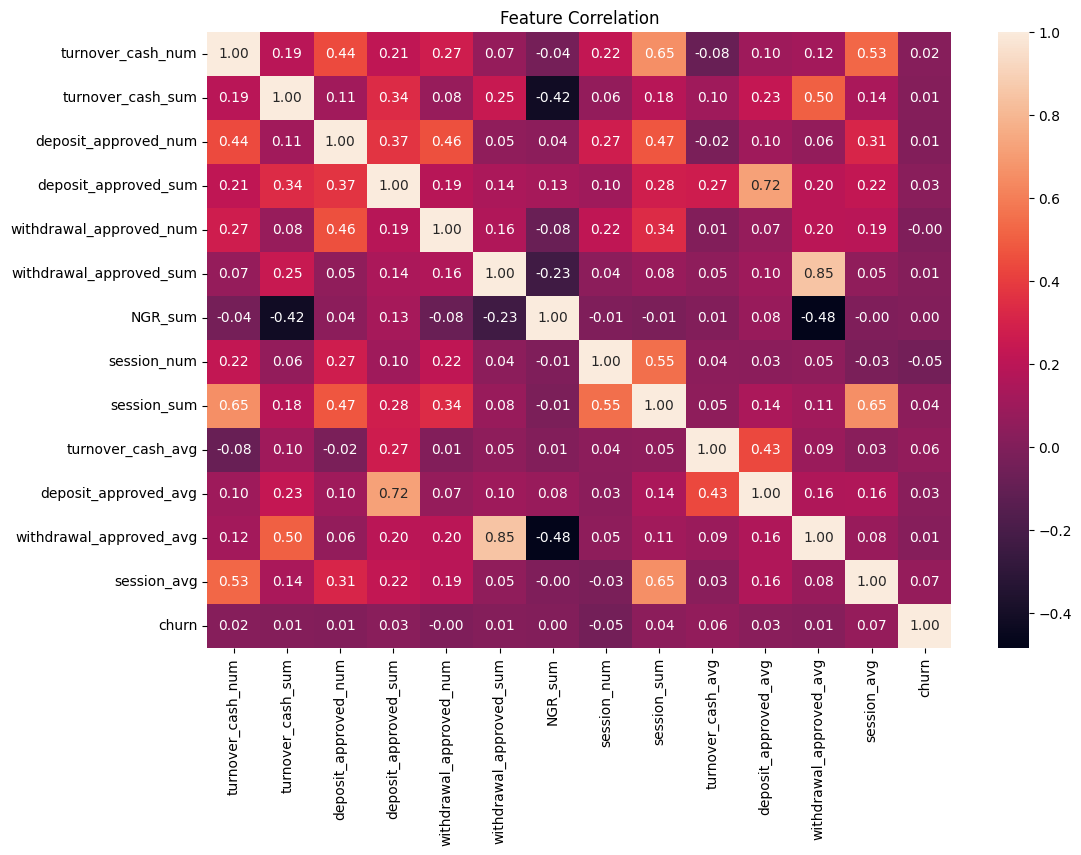

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.drop(['user_id',
 'date',
 'days_since_first_deposit',
 'days_to_first_activity',
 'days_since_activity',
 'days_to_first_turnover',
 'first_deposit_date'], axis=1).corr(), annot=True, fmt=".2f")

plt.title('Feature Correlation')
plt.show()

Here is the correlation heatmap for all the given and engineered features. It can be seen that calculated averages are heavily explained by the sums they are calculated from.

Some other highly correlated features include:

- NGR_sum vs. withdrawal_approved_avg
- session_avg vs. turnover_cash_num
- turnover_cash_sum vs. withdrawal_approved_avg

# Preparing train, test and target datasets


In [ ]:
# Prepare feature and target sets

# Target
y = df['churn']

# Features
X = df.drop(['user_id',
 'date',
 #'turnover_cash_num',
 #'turnover_cash_sum',
 #'deposit_approved_num',
 #'deposit_approved_sum',
 #'withdrawal_approved_num',
 #'withdrawal_approved_sum',
 'days_since_first_deposit',
 'days_to_first_activity',
 'days_since_activity',
 'days_to_first_turnover',
 #'session_num',
 #'session_sum',
 'first_deposit_date',
 'churn'], axis=1)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Exploratory analysis on training data

       turnover_cash_num  turnover_cash_sum  deposit_approved_num  \
count       45183.000000       4.518300e+04          45183.000000   
mean          930.191908       1.415868e+03              5.899409   
std          1800.175462       1.286864e+04              8.237215   
min             0.000000       0.000000e+00              0.000000   
25%             7.000000       3.330961e+01              0.000000   
50%           208.000000       2.258691e+02              4.000000   
75%           974.000000       9.671296e+02              7.000000   
max         32246.000000       2.420897e+06            180.000000   

       deposit_approved_sum  withdrawal_approved_num  withdrawal_approved_sum  \
count          45183.000000             45183.000000             45183.000000   
mean             221.513092                 1.125246               180.377851   
std              662.262322                 2.716848              1614.460729   
min                0.000000                 0.000000  

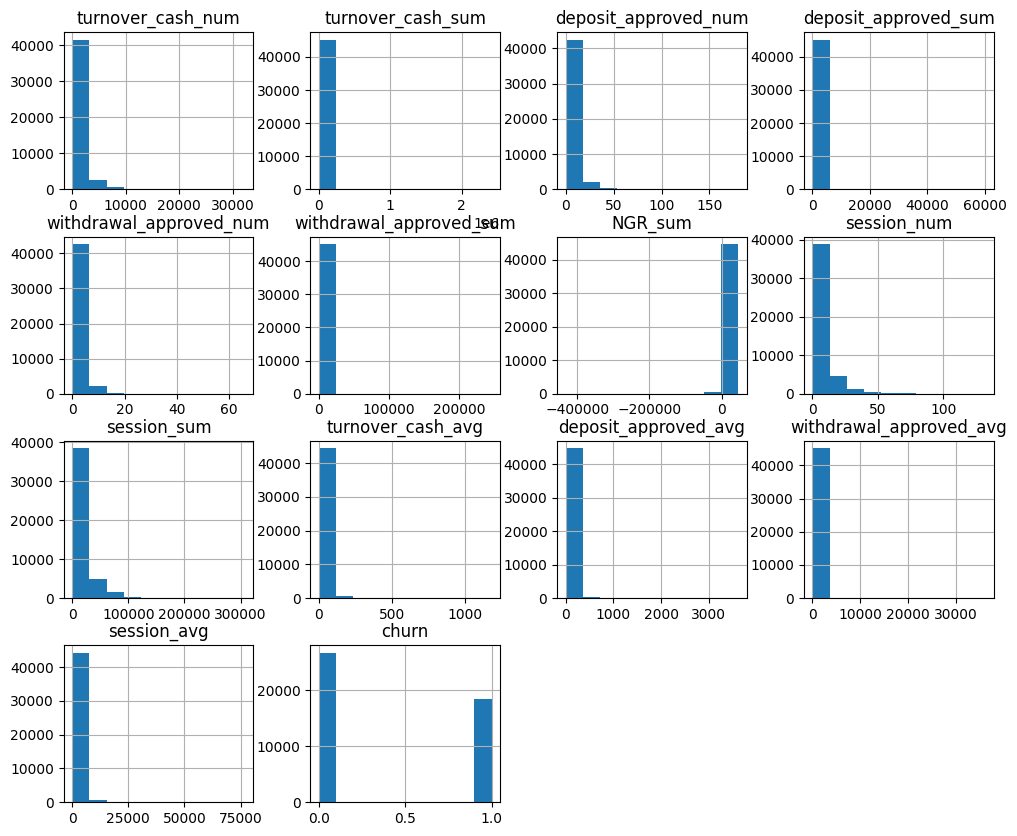

In [ ]:
# Do exploratory analysis on X_train combined with y_train
train_df = X_train.copy()
train_df['churn'] = y_train

# Descriptive statistics
print(train_df.describe())

# Class distribution
print(train_df['churn'].value_counts())

# Histograms for numerical features
train_df.hist(figsize=(12, 10))
plt.show()

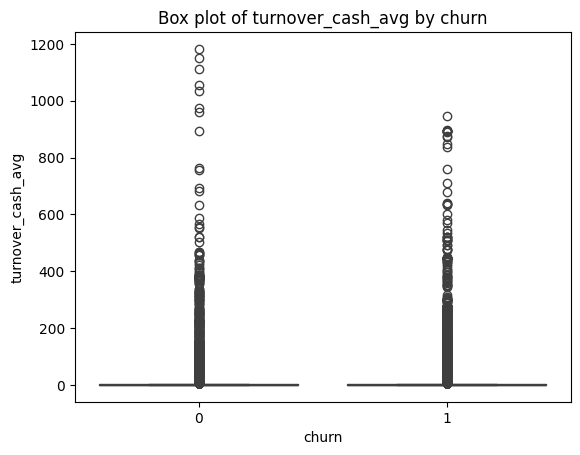

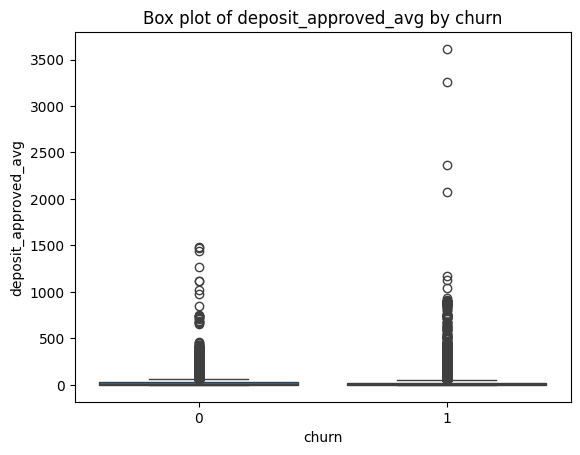

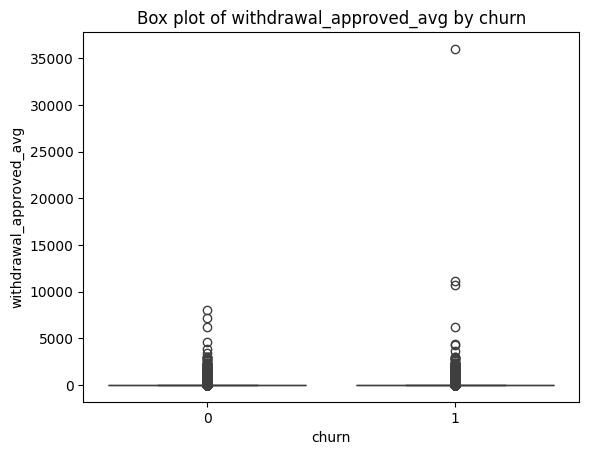

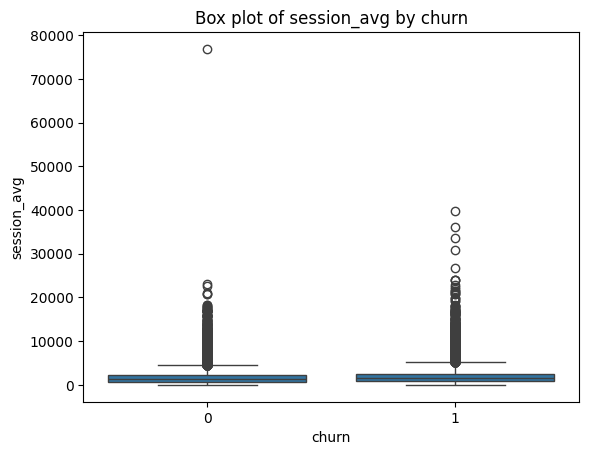

In [ ]:
# Box plots for average values grouped by churn
for column in ['turnover_cash_avg', 'deposit_approved_avg', 'withdrawal_approved_avg', 'session_avg']:
  plt.figure()
  sns.boxplot(x='churn', y=column, data=train_df)
  plt.title(f'Box plot of {column} by churn')
  plt.show()

Above, it can be seen that the spread of turnover cash, deposit and session averages are larger in customers which are labeled as no churn, whereas withdrawal average spread is larger for churn customers.

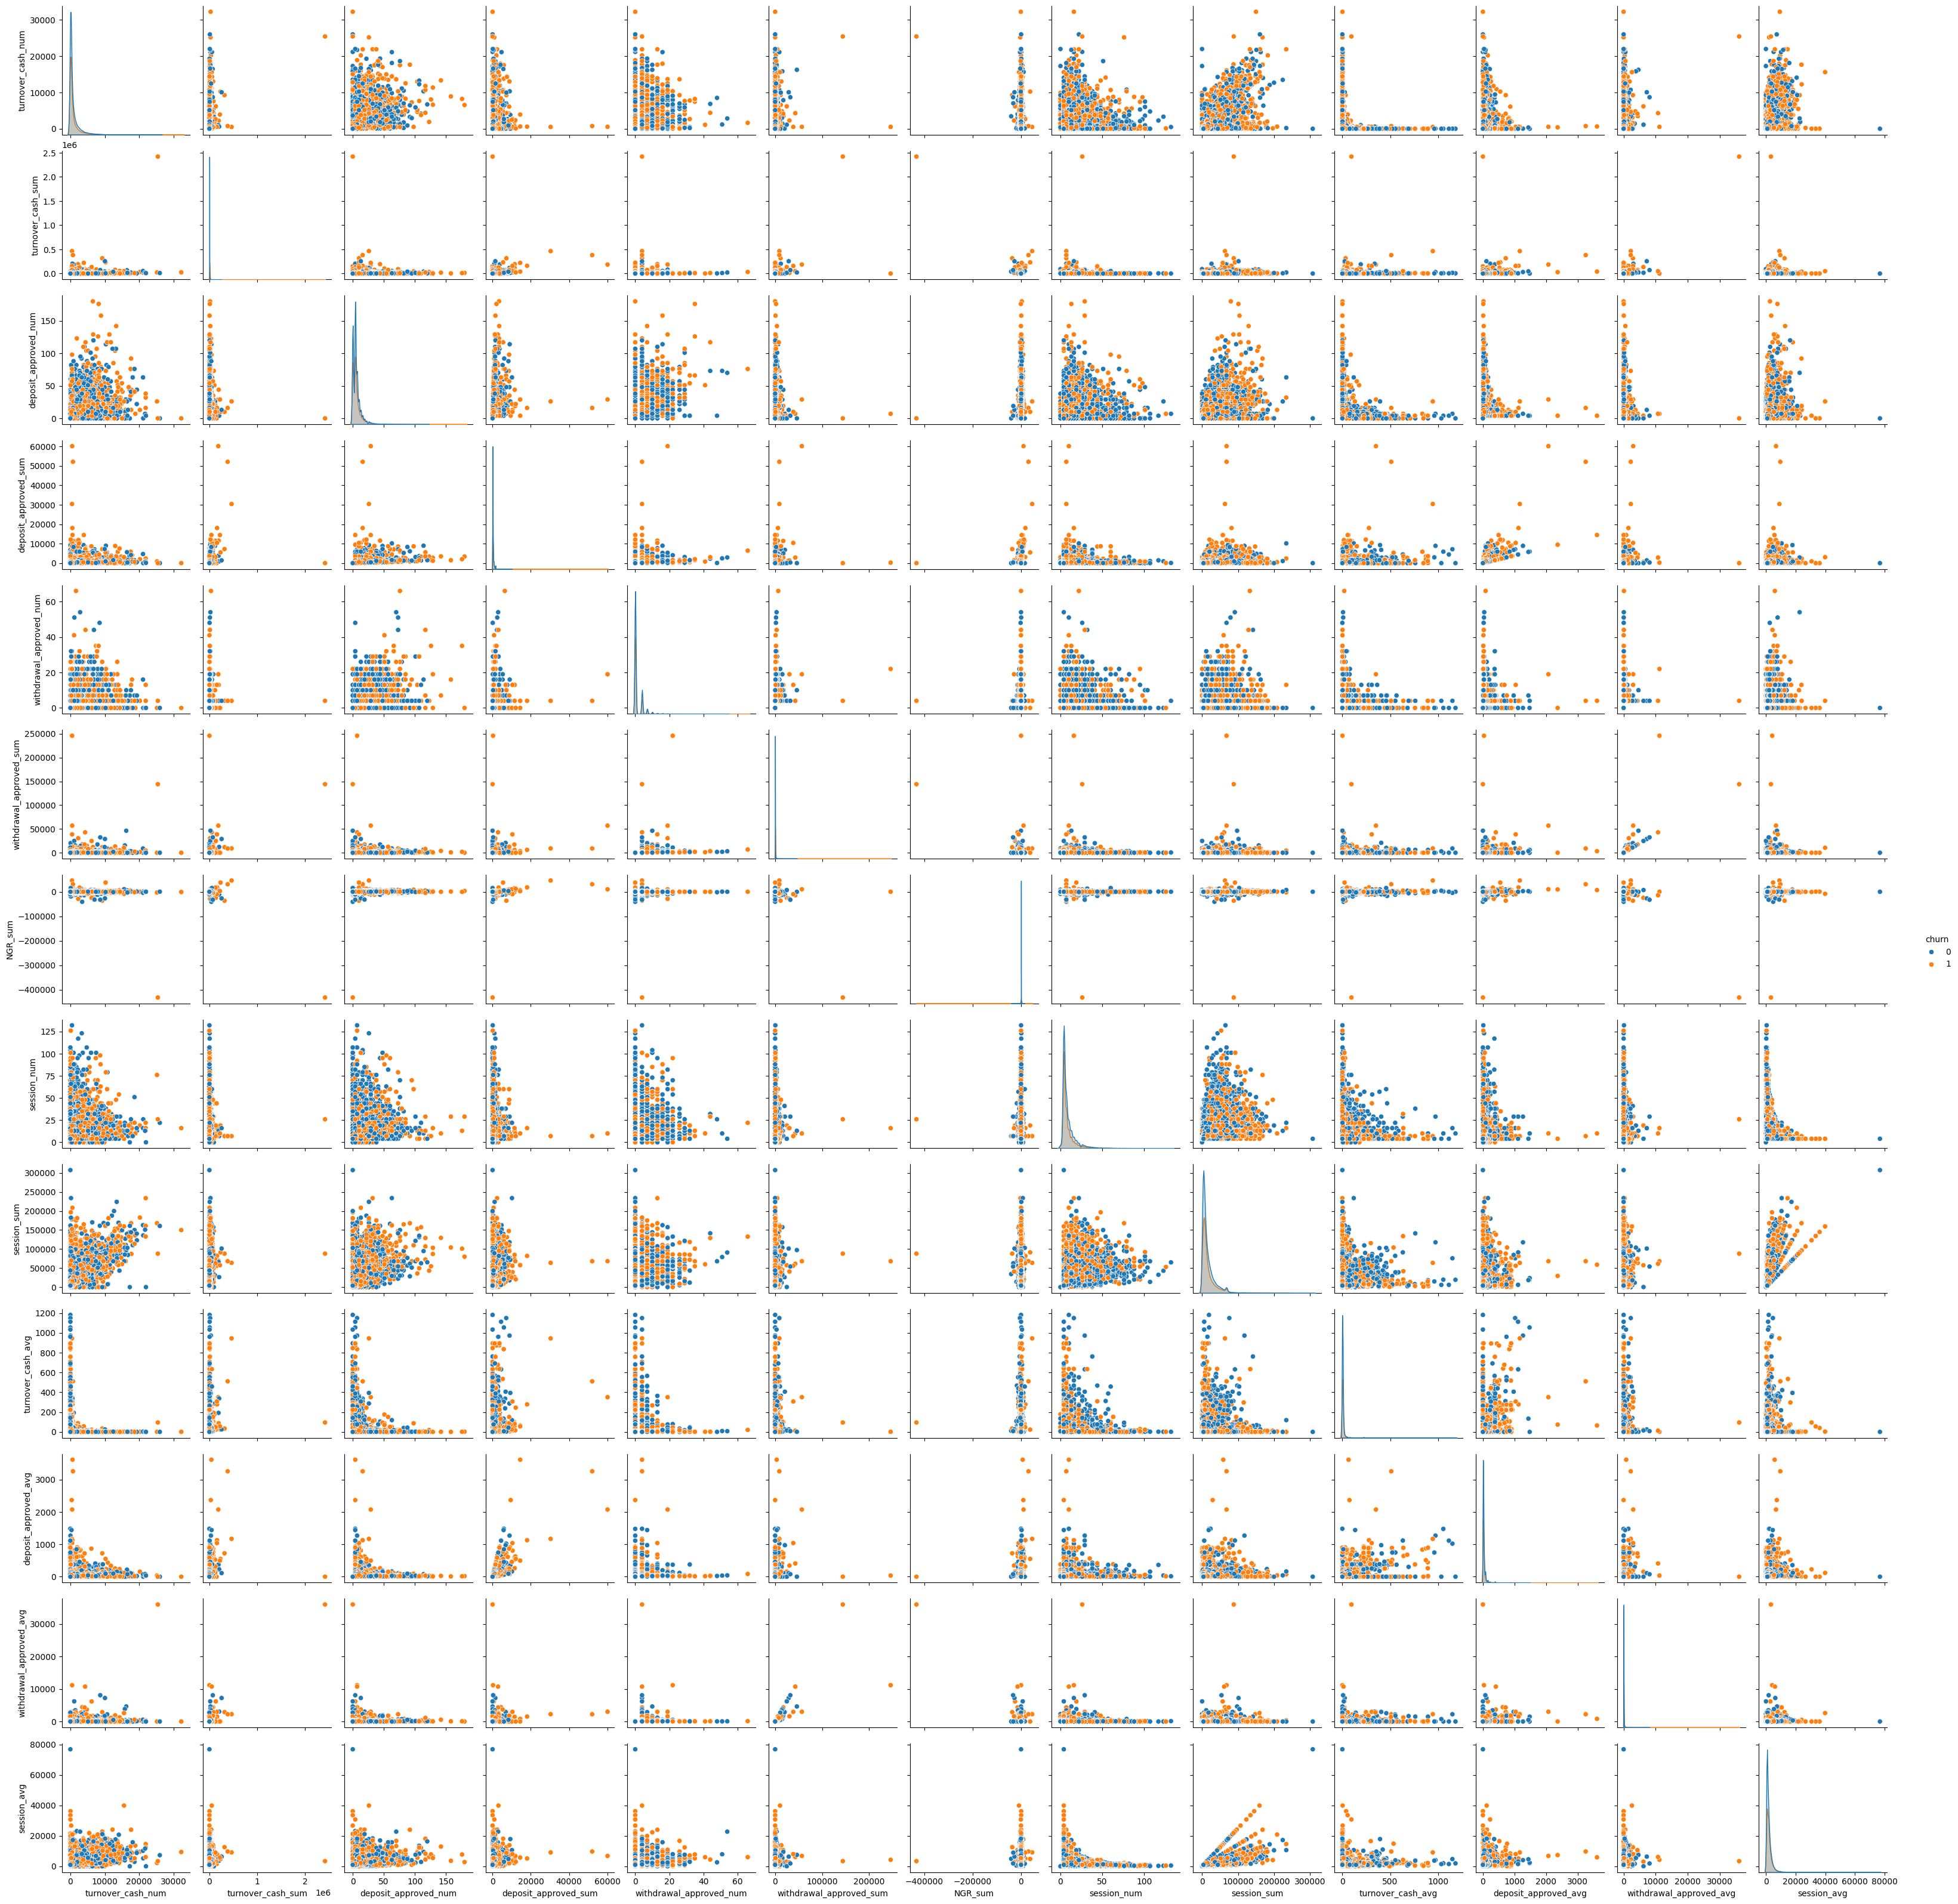

In [ ]:
# Pairplot for visualizing relationships between features
sns.pairplot(train_df, hue='churn')
plt.show()

It can be seen that there are some outliers in the data. These will not be taken out yet since scaling might reduce the disparity while still keeping the information coming from these data points which might be informative to the model.


# Pre-processing

In [ ]:
# Scale x_train and x_test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
train_scaled_df['churn'] = y_train

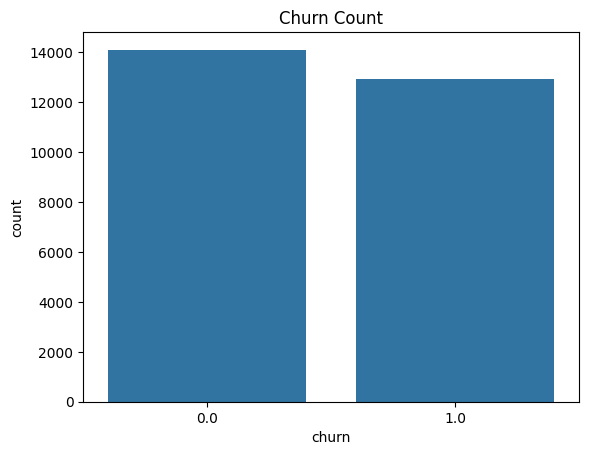

In [ ]:
# Churn labels summary
sns.countplot(x='churn', data=train_scaled_df)
plt.title('Churn Count')
plt.show()

Since the target labels are imbalanced, below we attempt to fix it by utilizing an oversampling algorithm.

In [ ]:
# Fix the imbalance in target set by oversampling

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
y_train_resampled = pd.DataFrame(y_train_resampled)

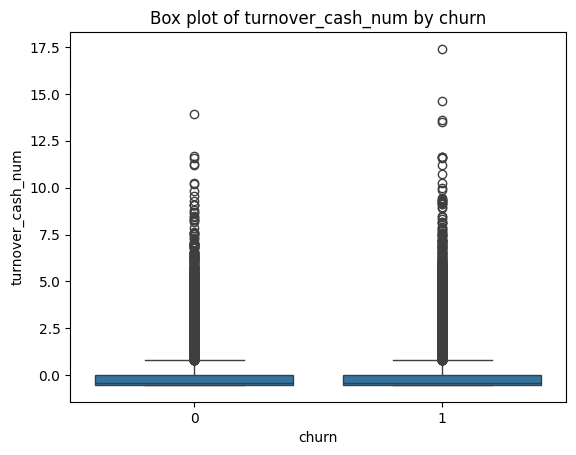

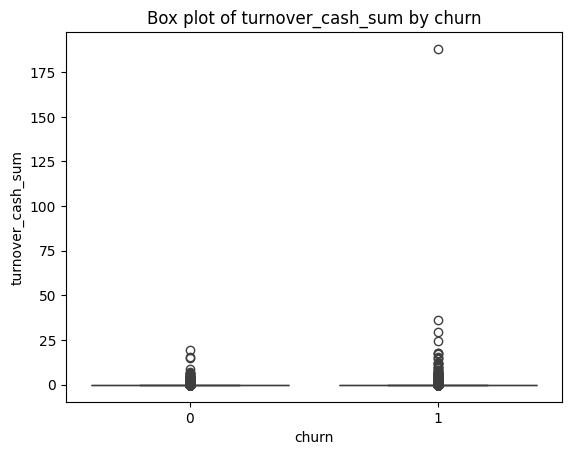

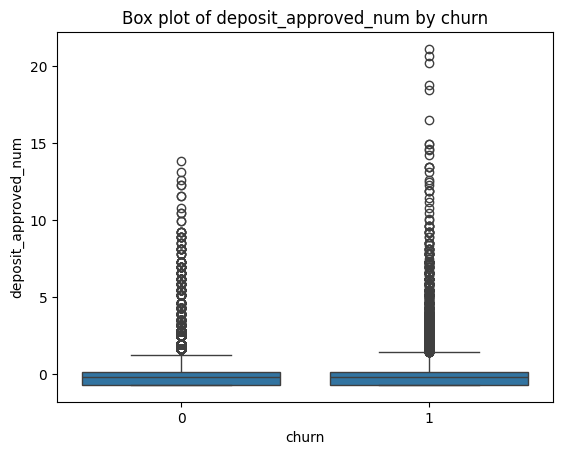

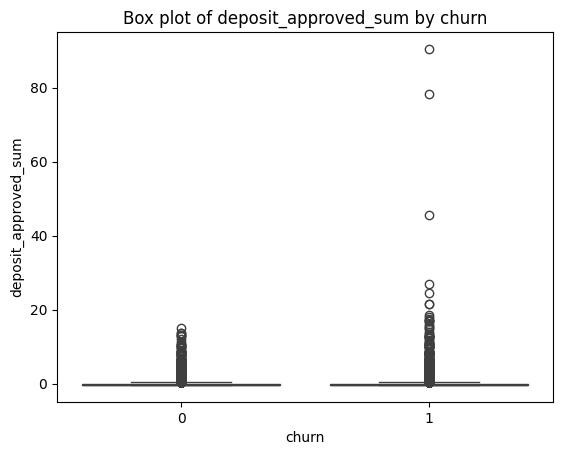

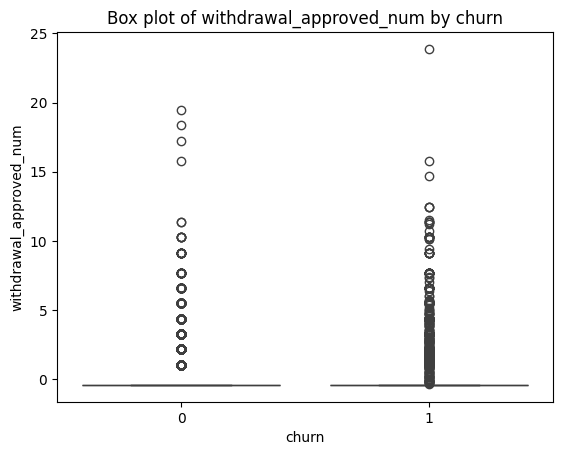

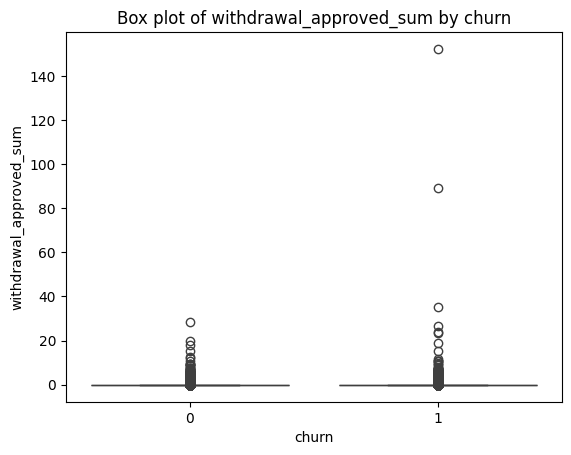

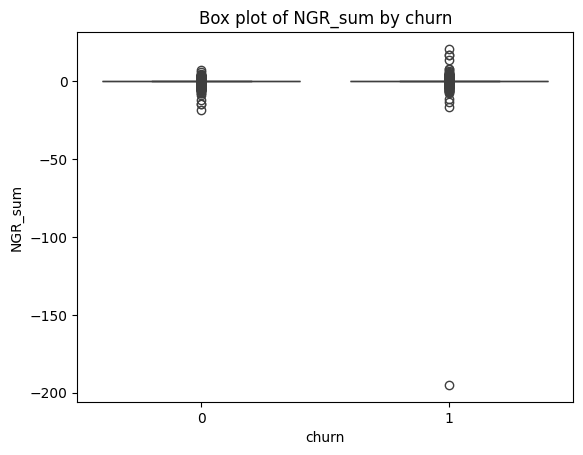

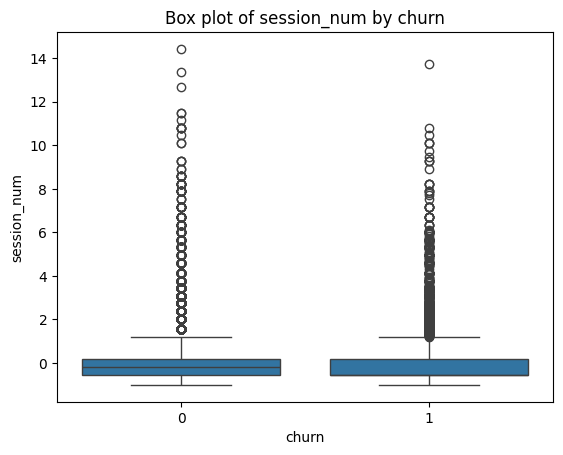

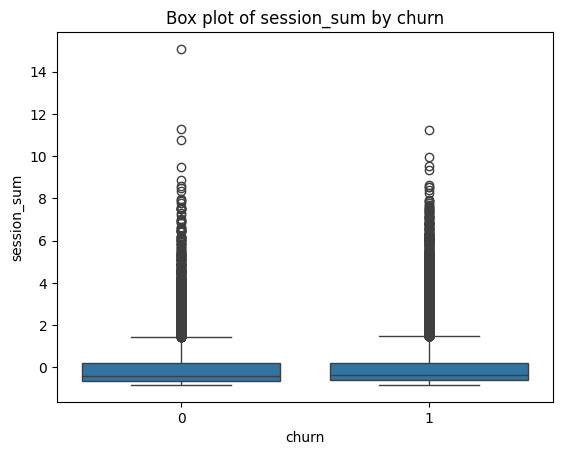

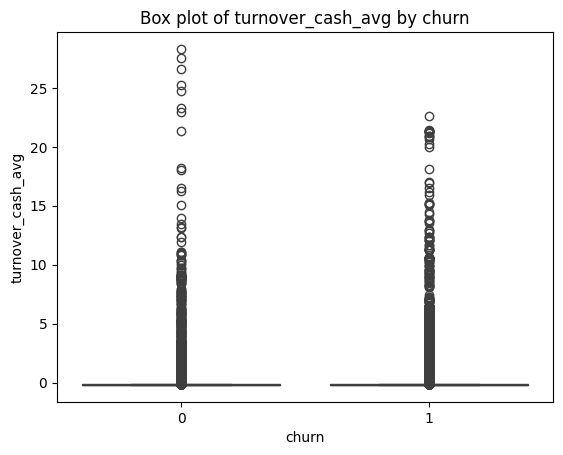

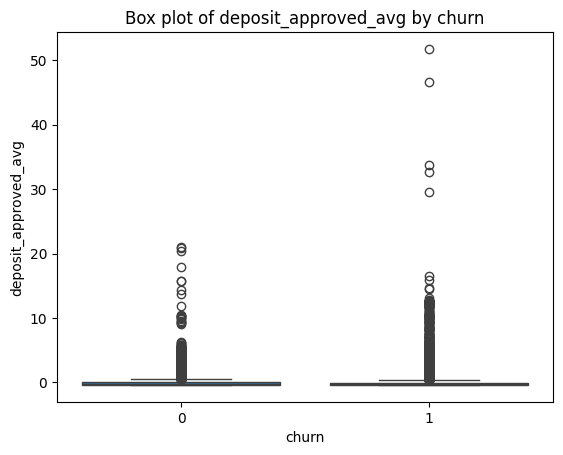

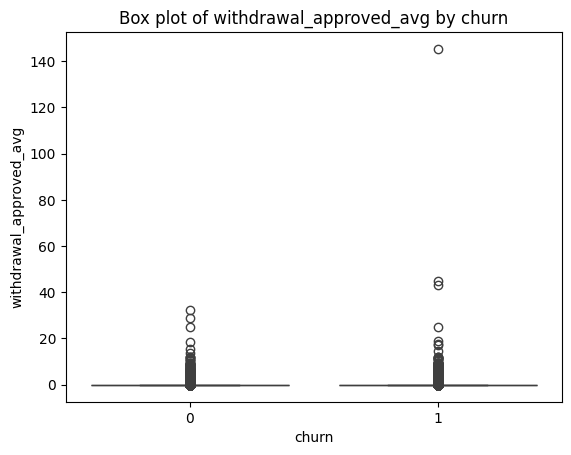

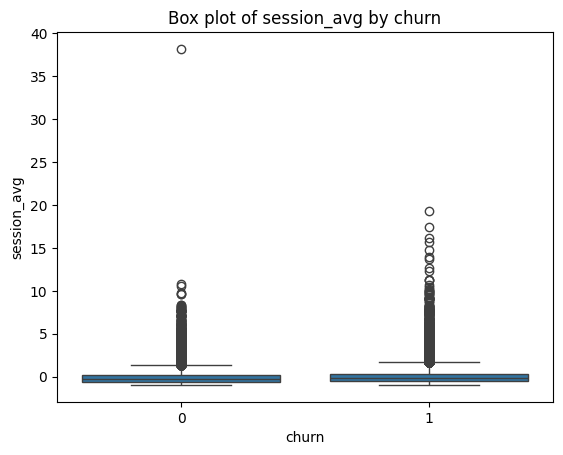

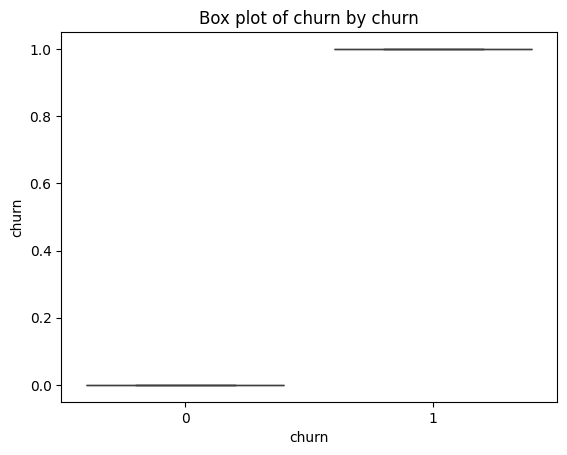

In [ ]:
# Consolidate the pre-processed data

train_df_resampled = X_train_resampled.copy()
train_df_resampled['churn'] = y_train_resampled

# Box plots for numerical features grouped by churn
for column in train_df_resampled.columns:
  plt.figure()
  sns.boxplot(x='churn', y=column, data=train_df_resampled)
  plt.title(f'Box plot of {column} by churn')
  plt.show()

Outliers look closer to the distribution of features after scaling so they will be kept during the analysis.

# Feature importance

                    Feature  Importance
12              session_avg    0.156397
8               session_sum    0.151700
6                   NGR_sum    0.114776
1         turnover_cash_sum    0.113469
0         turnover_cash_num    0.107303
3      deposit_approved_sum    0.101321
9         turnover_cash_avg    0.070887
10     deposit_approved_avg    0.063540
7               session_num    0.036914
2      deposit_approved_num    0.026127
5   withdrawal_approved_sum    0.024733
11  withdrawal_approved_avg    0.023172
4   withdrawal_approved_num    0.009662


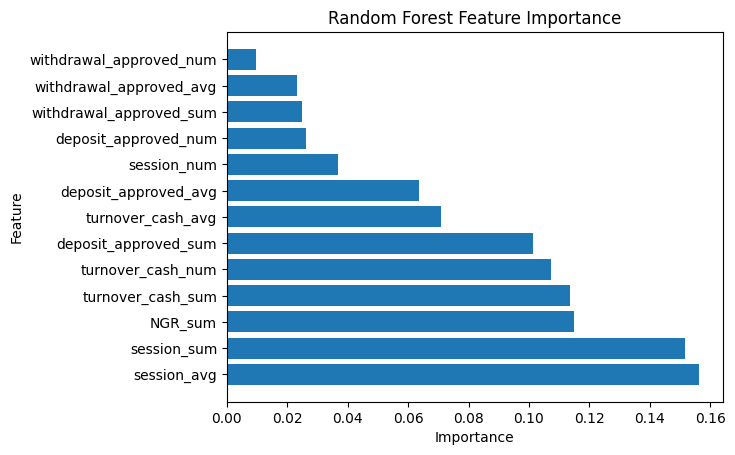

In [ ]:
# Assess feature importance
X = train_df_resampled.drop('churn', axis=1)
y = train_df_resampled['churn']

# Initialize Random Forest model
model = RandomForestClassifier()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Print or plot the feature importances
print(feature_importance_df)

# Plot
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

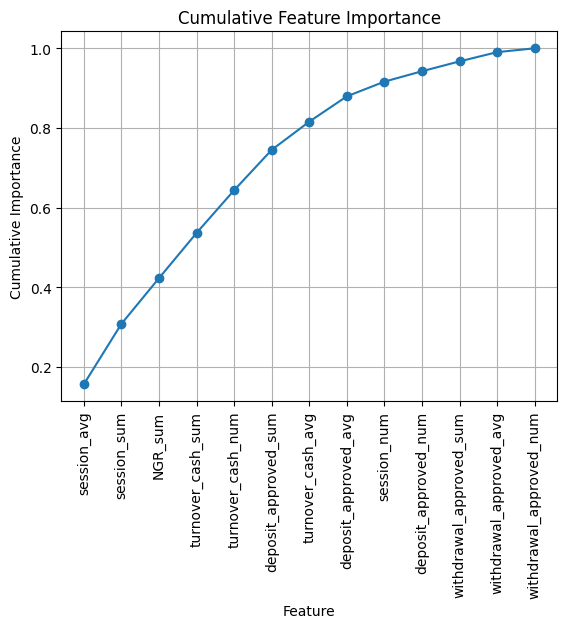

In [ ]:
# Calculate cumulative importance
feature_importance_df['Cumulative Importance'] = feature_importance_df['Importance'].cumsum()

# Find the number of features that explain 85% of the variance
num_features_85 = (feature_importance_df['Cumulative Importance'] <= 0.85).sum()

# Cumulative importance
plt.plot(feature_importance_df['Feature'], feature_importance_df['Cumulative Importance'], marker='o')
plt.xlabel('Feature')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Select the top features
top_features = feature_importance_df['Feature'][:num_features_85]

# Keep only the top features in the training and testing sets
X_train_selected = X_train_resampled[top_features]
X_test_selected = pd.DataFrame(X_test_scaled, columns=X_train.columns)[top_features]

train_df_selected = X_train_selected.copy()
train_df_selected['churn'] = y_train_resampled

To avoid overfitting but still hold on to enough information, we keep 85% of the features that explain the variability in the dataset.

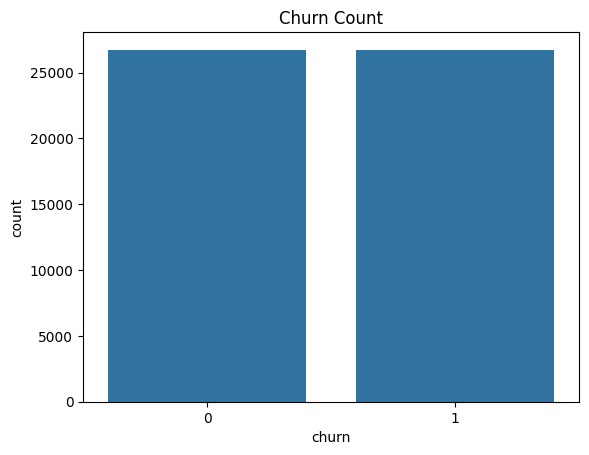

In [ ]:
# Churn labels summary
sns.countplot(x='churn', data=train_df_selected)
plt.title('Churn Count')
plt.show()

Now that we have a balanced target set, we can go on to pick a model for our problem.

# Selection of the best performing model

In [ ]:
X_train_final = X_train_selected.copy()
X_test_final = X_test_selected.copy()

y_train_final = y_train_resampled.copy()
y_test_final = y_test.copy()

# Define models to try
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

# Dictionary to hold results
results = {}

for model_name, model in models.items():
    # Fit the model
    model.fit(X_train_final, y_train_final)

    # Make predictions
    y_pred = model.predict(X_test_final)
    y_prob = model.predict_proba(X_test_final)[:, 1]

    # Evaluate model
    report = classification_report(y_test_final, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test_final, y_prob)

    results[model_name] = {
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1-score': report['1']['f1-score'],
        'roc_auc': roc_auc
    }

# Output model results
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='roc_auc', ascending=False))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

                        precision    recall  f1-score   roc_auc
Gradient Boosting        0.546819  0.470976  0.506071  0.647563
Random Forest            0.531646  0.474634  0.501525  0.629334
AdaBoost                 0.511626  0.475854  0.493092  0.616428
Support Vector Machine   0.522210  0.442520  0.479074  0.610077
K-Nearest Neighbors      0.467410  0.524715  0.494408  0.576285
Decision Tree            0.470168  0.481138  0.475590  0.556388
Logistic Regression      0.475017  0.388780  0.427594  0.552461


ROC-AUC values are assessed to choose the best fitting model since they give a more comprehensive understanding of how the classifier is performing.

Hence, the Gradient Boosting model is selected.

# Hyper-parameter tuning for the best model

In [ ]:
# Hyperparameter tuning for gradient boost

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Initialize Gradient Boosting model
model = GradientBoostingClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_final, y_train_final)

# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best ROC AUC score:  0.7072404847261599


# Prediction and metrics

In [ ]:
# Predict on test set
y_pred_gb = best_model.predict(X_test_final)

# Evaluate Gradient Boosting model
print(classification_report(y_test_final, y_pred_gb))

# ROC AUC score for Gradient Boosting
y_prob_gb = best_model.predict_proba(X_test_final)[:, 1]
roc_auc_gb = roc_auc_score(y_test_final, y_prob_gb)
print("ROC AUC Score (Gradient Boosting):", roc_auc_gb)

              precision    recall  f1-score   support

           0       0.67      0.72      0.70     17822
           1       0.55      0.49      0.52     12300

    accuracy                           0.63     30122
   macro avg       0.61      0.61      0.61     30122
weighted avg       0.62      0.63      0.62     30122

ROC AUC Score (Gradient Boosting): 0.6554178470384188


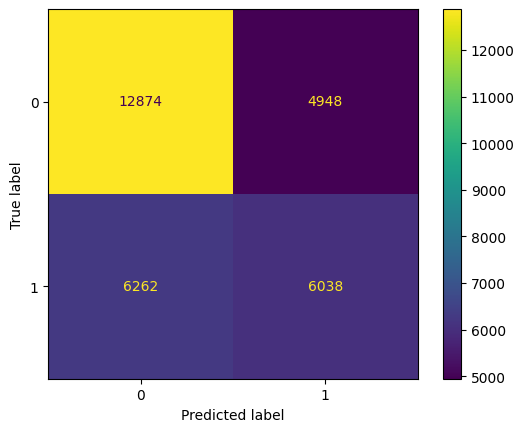

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test_final, y_pred_gb)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Combine y_test y_pred and unscaled X_test
results_df = pd.DataFrame(X_test)
results_df['y_test'] = y_test
results_df['y_pred_gb'] = y_pred_gb
results_df.to_csv('results.csv', index=False)
results_df.head()

turnover_cash_num  turnover_cash_sum  deposit_approved_num  \
50769                171         106.907219                     4   
27068                  0           0.000000                     0   
46643                447         276.274504                     4   
44188                  7         127.490690                     4   
60128               1223        1722.086671                    10   

       deposit_approved_sum  withdrawal_approved_num  withdrawal_approved_sum  \
50769             45.817380                        0                 0.000000   
27068              0.000000                        0                 0.000000   
46643             90.680910                        4                60.713892   
44188            119.709568                        0                 0.000000   
60128            677.544344                        0                 0.000000   

          NGR_sum  session_num   session_sum  turnover_cash_avg  \
50769  -28.254051            7   6342.875568                1.0   
27068    0.000000           13   6814.114466                0.0   
46643   30.045608            4   6408.849013                1.0   
44188   63.745345           19  12563.229022               18.0   
60128  677.513121            7  16062.963238                1.0   

       deposit_approved_avg  withdrawal_approved_avg  session_avg  y_test  \
50769                  11.0                      0.0        906.0       0   
27068                   0.0                      0.0        524.0       1   
46643                  23.0                     15.0       1602.0       1   
44188                  30.0                      0.0        661.0       1   
60128                  68.0                      0.0       2295.0       0   

       y_pred_gb  
50769          1  
27068          0  
46643          0  
44188          0  
60128          0

In [ ]:
# Create another column  stating 1 if y_test and y_pred_gb are the same value and 0 otherwise
results_df['correct_prediction'] = (results_df['y_test'] == results_df['y_pred_gb']).astype(int)
results_df.head()

turnover_cash_num  turnover_cash_sum  deposit_approved_num  \
50769                171         106.907219                     4   
27068                  0           0.000000                     0   
46643                447         276.274504                     4   
44188                  7         127.490690                     4   
60128               1223        1722.086671                    10   

       deposit_approved_sum  withdrawal_approved_num  withdrawal_approved_sum  \
50769             45.817380                        0                 0.000000   
27068              0.000000                        0                 0.000000   
46643             90.680910                        4                60.713892   
44188            119.709568                        0                 0.000000   
60128            677.544344                        0                 0.000000   

          NGR_sum  session_num   session_sum  turnover_cash_avg  \
50769  -28.254051            7   6342.875568                1.0   
27068    0.000000           13   6814.114466                0.0   
46643   30.045608            4   6408.849013                1.0   
44188   63.745345           19  12563.229022               18.0   
60128  677.513121            7  16062.963238                1.0   

       deposit_approved_avg  withdrawal_approved_avg  session_avg  y_test  \
50769                  11.0                      0.0        906.0       0   
27068                   0.0                      0.0        524.0       1   
46643                  23.0                     15.0       1602.0       1   
44188                  30.0                      0.0        661.0       1   
60128                  68.0                      0.0       2295.0       0   

       y_pred_gb  correct_prediction  
50769          1                   0  
27068          0                   0  
46643          0                   0  
44188          0                   0  
60128          0                   1

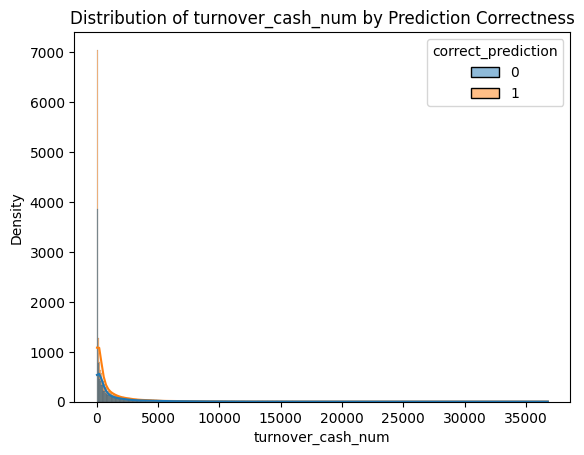

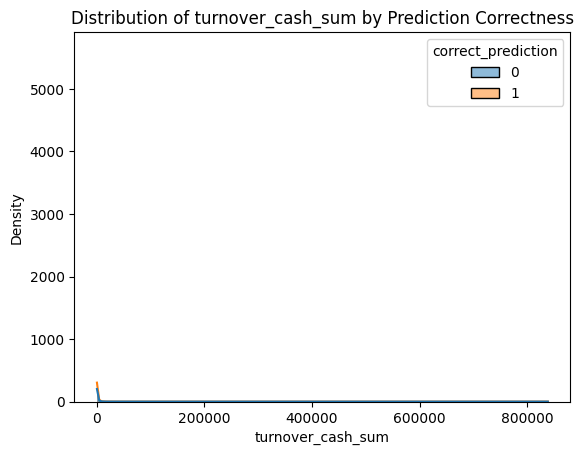

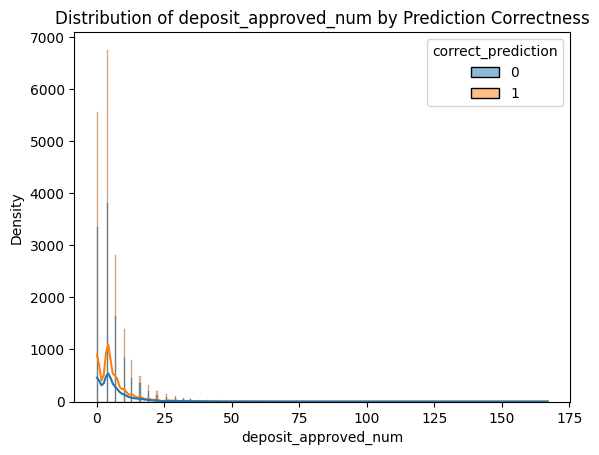

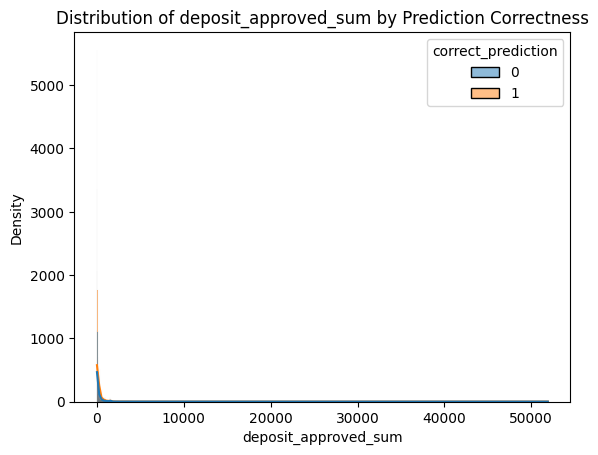

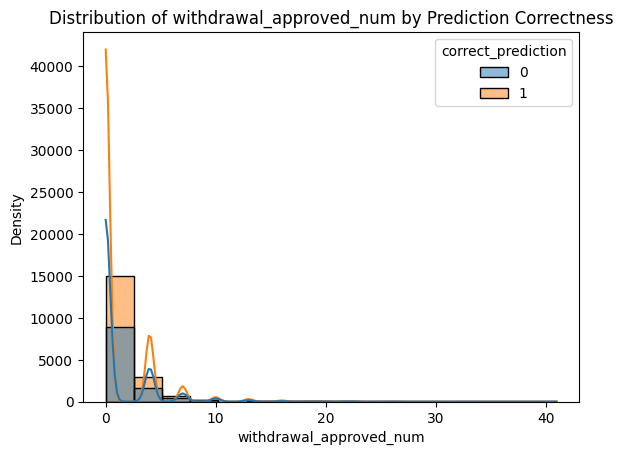

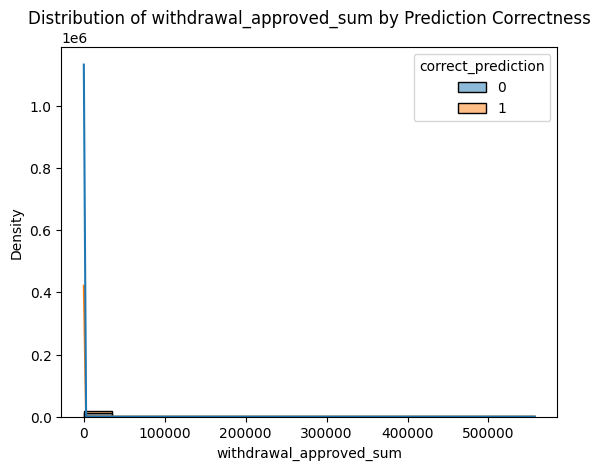

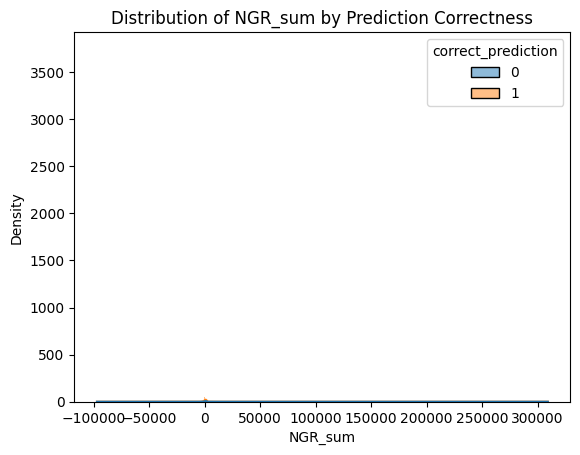

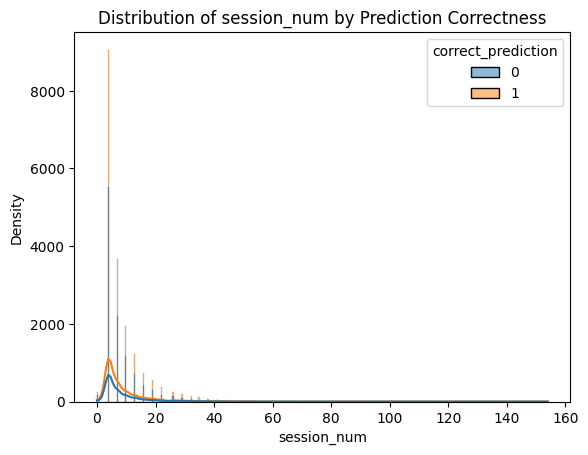

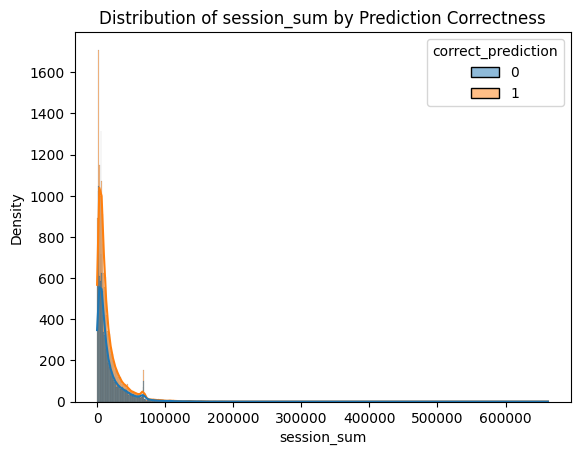

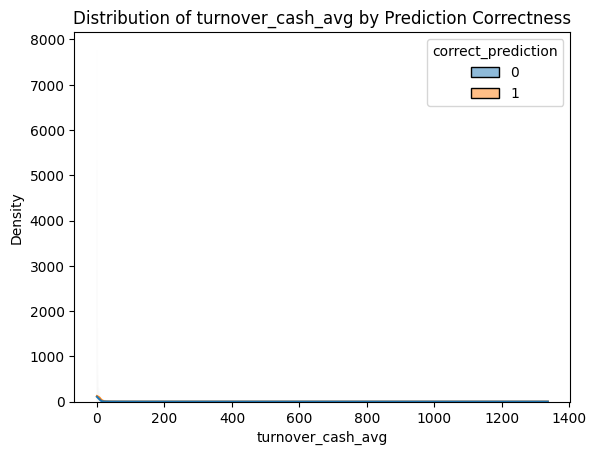

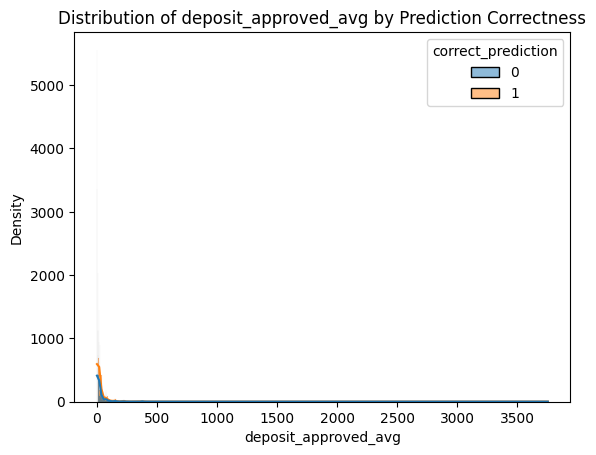

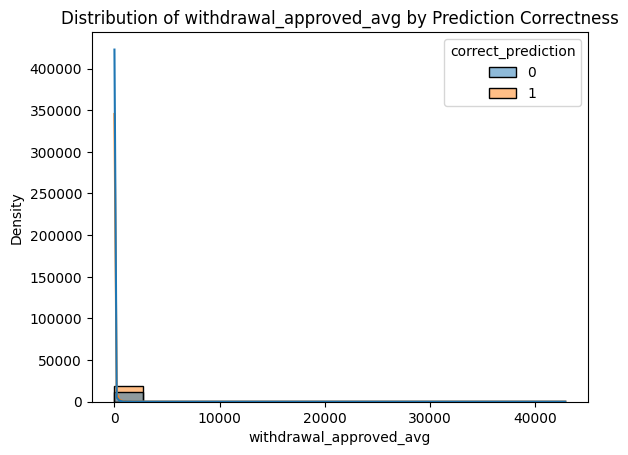

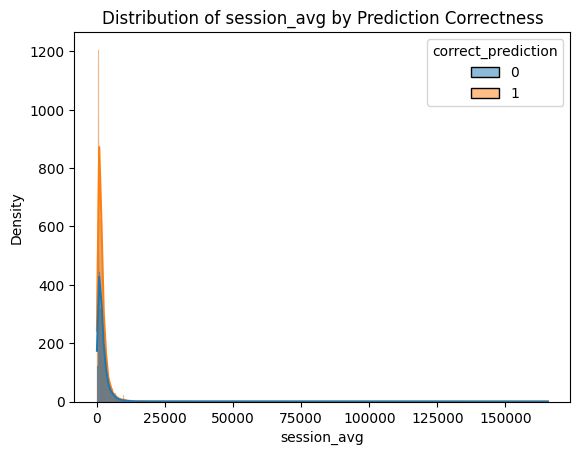

In [ ]:
# Plot distributions for correct and incorrect predictions
for column in results_df.columns[:-3]:
    plt.figure()
    sns.histplot(data=results_df, x=column, hue='correct_prediction', kde=True)
    plt.title(f'Distribution of {column} by Prediction Correctness')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()

Each feature's SHAP value represents the impact of that feature on the model's predicted output, compared to a baseline (typically the average prediction). A positive SHAP value indicates that the feature increases the prediction, while a negative value suggests that it decreases the prediction.

100%|===================| 30028/30122 [02:00<00:00]       

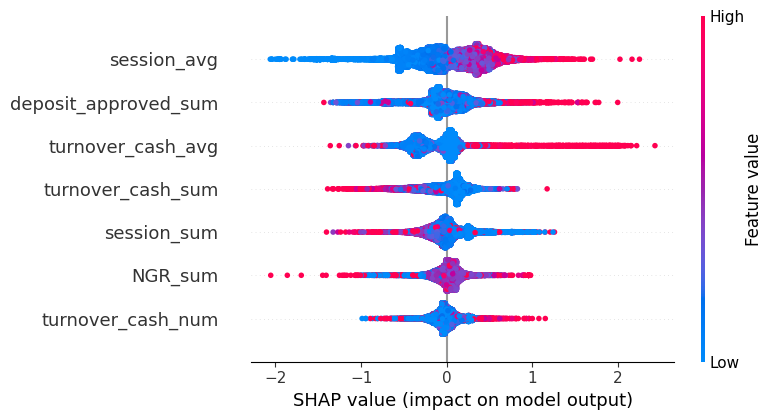

In [ ]:
# Create a SHAP explainer
explainer = shap.Explainer(best_model, X_train_final)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_final, check_additivity=False)

# Summary plot
shap.summary_plot(shap_values, X_test_final)

The magnitude of SHAP values for each feature across the dataset indicates the importance of that feature to the model. Higher absolute SHAP values suggest a greater impact on the model’s predictions.

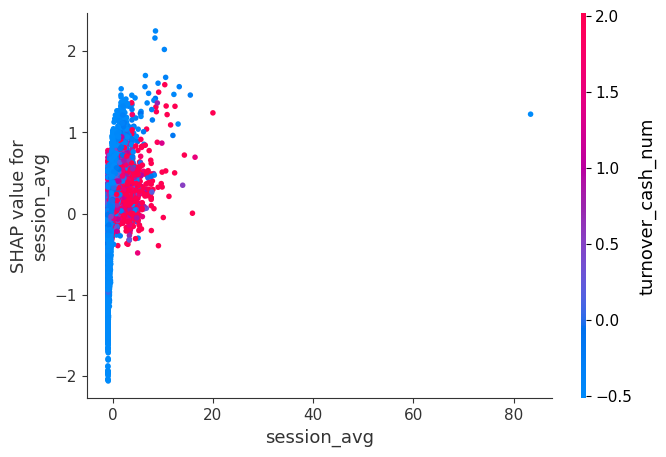

In [ ]:
shap.dependence_plot(0, shap_values.values, X_test_final, feature_names=X_test_final.columns, interaction_index='auto')

This plots the SHAP value of a feature against its value, showing how the feature influences predictions.

# Conclusions

The selected model gives comparable scores for training and test sets with ROC-AUC scores close to 0.7. This tells us that we are not suffering from overfitting or underfitting. However, from the confusion matrix, it can be seen that we are still missing a lot of churn cases. This is where the efforts should focus to improve the model further so that the churn possibilities are minimized for the maximum amount of customers.

The performance may be improved by engineering different features, collecting more data as well as combining several models to achieve a more robust prediction. Date information can be added categorically to enhance the time series format of the data. This provides better results when done numerically, however is excluded in this exercise due to the possibility of numerical values artifically increasing the correlation between features.

The shortcomings of the model can be further examined by unsupervised clustering algorithms which would indicate around which value spaces of features the faulty predictions are made. Then, an in-detail case by case study for selected customers would provide much more insight into where model fails or succeeds.

The model can be improved immensely if the actual historical churn values are used for training.

The code can easily be modularized and packaged for further use.